In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import model_selection, svm, metrics, neighbors, linear_model, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import itertools

In [39]:
import numpy as np 

def load_file(file_name):
    with open(file_name, 'rb') as file:
        return np.load(file)        

In [40]:
folder_save = '../dataset'
scaled_matrix = load_file(f"{folder_save}/scale_matrix.npy")

In [41]:
selected_customers = pd.read_csv('../dataset/selected_customers.csv')

# Phân cụm khách hàng

### Tìm số lượng cụm

In [26]:
silhouette_values = []

for n_clusters in range(3,15):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    silhouette_values.append(silhouette_avg)

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.12507972070524984
For n_clusters = 4 The average silhouette_score is : 0.13713689423547604
For n_clusters = 5 The average silhouette_score is : 0.1514915202442932
For n_clusters = 6 The average silhouette_score is : 0.14846816789795333
For n_clusters = 7 The average silhouette_score is : 0.17355202361419034
For n_clusters = 8 The average silhouette_score is : 0.18377016346987216
For n_clusters = 9 The average silhouette_score is : 0.19161517261146352
For n_clusters = 10 The average silhouette_score is : 0.17425944347153657
For n_clusters = 11 The average silhouette_score is : 0.19001964397860652
For n_clusters = 12 The average silhouette_score is : 0.18379786409298654
For n_clusters = 13 The average silhouette_score is : 0.18738711297376134
For n_clusters = 14 The average silhouette_score is : 0.17882645026089594


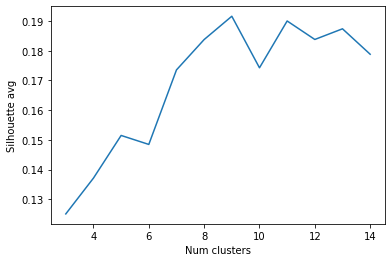

In [27]:
plt.plot(list(range(3,15)), silhouette_values)
plt.xlabel("Num clusters")
plt.ylabel("Silhouette avg")
plt.show()

### Chọn số lượng cụm là 9

In [30]:
n_clusters = 9
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score for silhouette {:<.3f}'.format(silhouette_avg))

score for silhouette 0.192


In [31]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['Number of values']).T

,1,8,7,3,2,0,5,4,6
Number of values,237,168,163,113,101,96,74,9,2


### Đánh giá chất lượng của phân tách thông qua các điểm Silouhette trong các cụm khác nhau

In [32]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):

        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)

        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))

        y_lower = y_upper + 10  

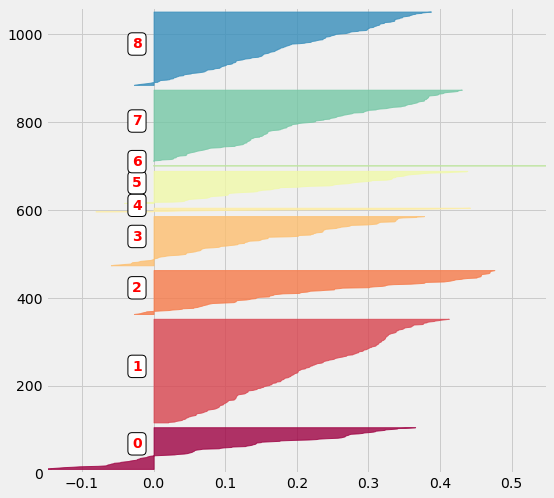

In [33]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

# Hình thái khách hàng

In [42]:
selected_customers.loc[:, 'cluster'] = clusters_clients
selected_customers

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,LastPurchase,FirstPurchase,cluster
0,12347.0,1,711.79,711.79,711.790,711.79,17.482684,3.287486,11.716939,26.299892,38.051954,3.161045,33,33,0
1,12348.0,1,652.80,652.80,652.800,652.80,0.000000,73.345588,0.000000,26.654412,0.000000,0.000000,24,24,3
2,12370.0,2,157.20,1587.07,872.135,1744.27,7.157722,9.958321,32.830353,35.958883,11.775700,2.319022,23,26,0
3,12377.0,1,1001.52,1001.52,1001.520,1001.52,0.000000,9.837048,21.926671,32.710280,35.526000,0.000000,20,20,0
4,12383.0,1,543.72,543.72,543.720,543.72,0.000000,41.679541,0.000000,39.174575,8.717722,10.428162,18,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,18245.0,1,365.73,365.73,365.730,365.73,0.000000,34.118065,13.124436,33.549340,19.208159,0.000000,21,21,3
959,18259.0,1,376.30,376.30,376.300,376.30,0.000000,0.000000,21.445655,13.393569,65.160776,0.000000,32,32,7
960,18260.0,2,230.70,538.82,384.760,769.52,9.278511,18.832519,26.003223,28.474893,3.859549,13.551305,0,24,1
961,18269.0,1,138.90,138.90,138.900,138.90,0.000000,14.686825,0.000000,28.509719,56.803456,0.000000,32,32,7


In [43]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 963


In [44]:
liste_index = []
for i in range(6):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] == merged_df[column].max()].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]

In [46]:
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0','categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5', 'size']]

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,size
0,6.0,35.500000,11.575000,505.625000,127.929829,4525.385000,21.762130,9.545792,21.126246,20.613296,24.853672,2.098863,2
1,1.0,1.451477,233.595527,291.896962,262.820381,378.994684,8.903064,13.208458,18.296441,42.614429,11.962809,5.064411,237
2,2.0,1.366337,201.596634,269.195941,235.614827,336.422475,6.180089,5.330207,60.863252,12.768120,7.965023,6.893309,101
3,3.0,1.380531,205.845929,260.065398,228.354050,332.072655,9.404597,45.196320,14.400655,17.896689,8.917293,4.184447,113
4,4.0,1.666667,2157.394444,3083.691111,2606.804444,4169.980000,11.512982,14.812885,17.453344,25.768840,15.349785,15.102165,9
5,5.0,1.351351,254.057973,281.628378,266.772410,345.422162,9.345125,11.462579,14.938440,14.852098,10.820703,38.586255,74
6,8.0,1.684524,232.053333,313.819940,271.570340,466.585417,41.286685,12.491357,13.614702,14.266467,13.679313,4.757329,168
7,7.0,1.613497,204.162331,299.628896,247.189157,424.491840,9.860508,8.093339,16.562032,13.203389,47.333417,5.024468,163
8,0.0,2.197917,666.752396,1160.344063,871.570440,1874.165625,13.363242,15.647488,20.852430,22.545059,19.573704,8.018077,96


### Phân tích tính chất của từng cụm thông qua biểu đồ Rada

In [47]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid[:-1], labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

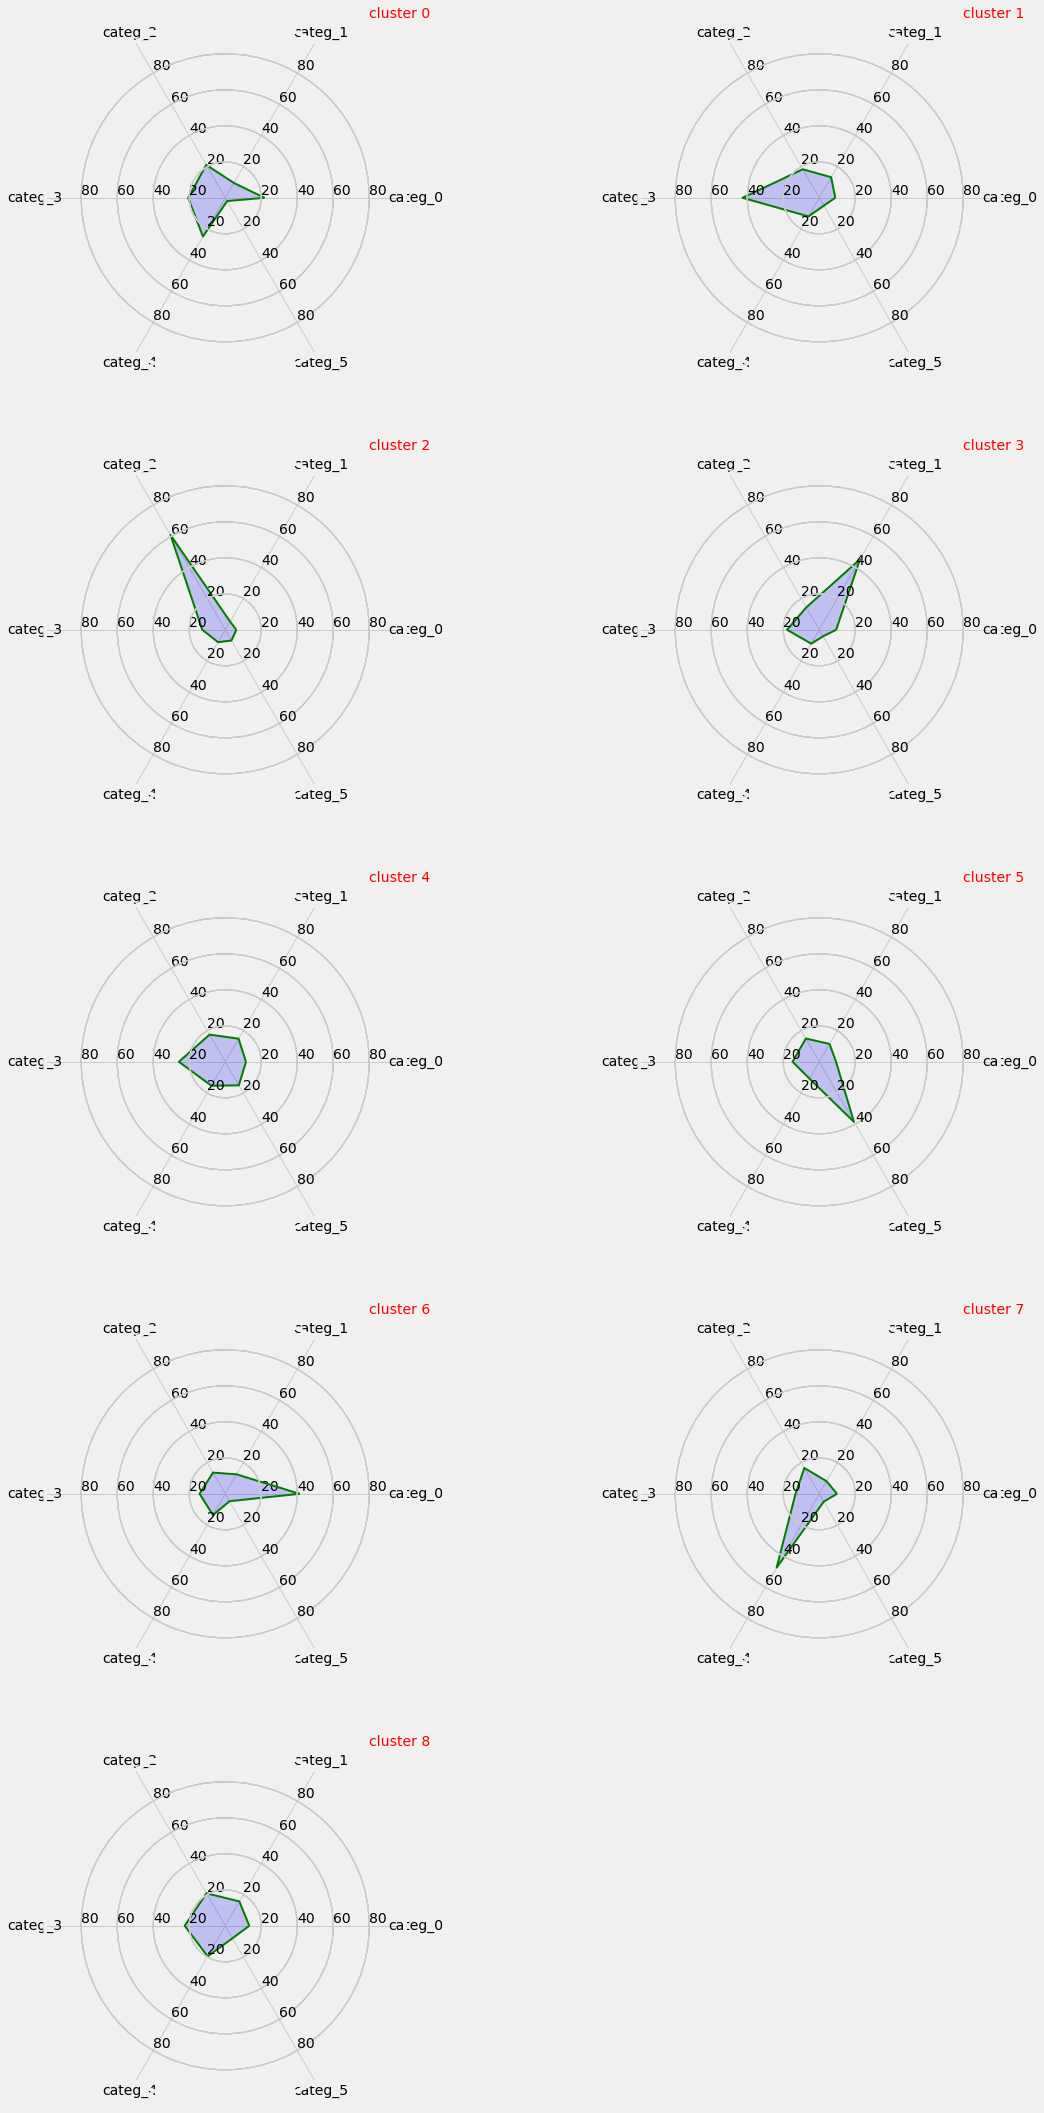

In [49]:
fig = plt.figure(figsize=(15,20))

# attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
# ranges = [[0.01, 10], [0.01, 3000], [0.01, 6000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]

attributes = ['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5']
ranges = [[0.01, 100], [0.01, 100], [0.01, 100], [0.01, 100], [0.01, 100],[0.01, 100]]
index  = [0, 1, 2, 3, 4, 5, 6, 7,8]

n_groups = n_clusters ; i_cols = 2
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%2 ; iy = i_rows - ind//2
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'g', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster {}'.format(index[ind]), color = 'r')
    ind += 1 

### 5 cụm đầu tiên có mức độ ưu tiên cao hơn với một danh mục cụ thể
### Cụm thứ 6 có sự phân bổ đồng đều giữa các danh mục sản phảm
### Cụm thứ 7 ưu thích mua các sản phẩm có giá trị cao
### Cụm thứ 8 ưu tiên mua nhiều sản phẩm do đó tổng giá trị đơn hàng sẽ cao lên

In [50]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [51]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [52]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [53]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [ ]:
svc.grid_fit(X = X_train, Y = Y_train)

In [55]:
svc.grid_predict(X_test, Y_test)

Precision: 83.42 % 


In [56]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


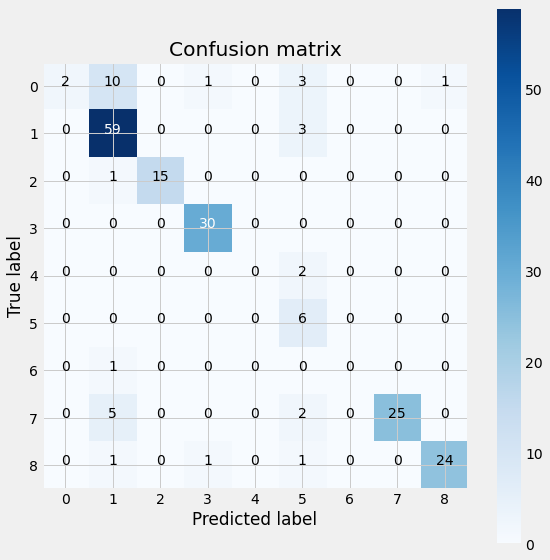

In [57]:
class_names = [i for i in range(n_clusters)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [58]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


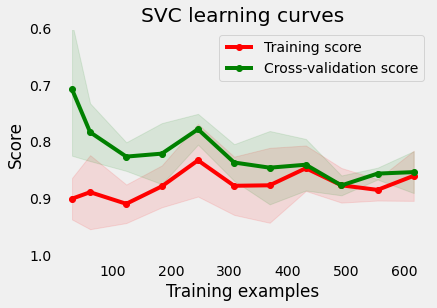

In [59]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

## Logistic regression

In [ ]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


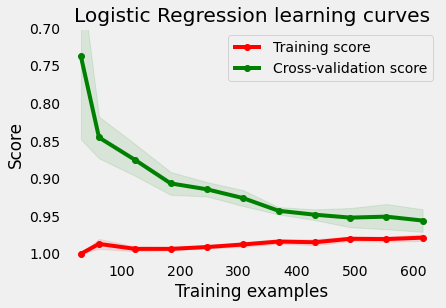

In [61]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## KNN

In [62]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Precision: 82.38 % 


f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


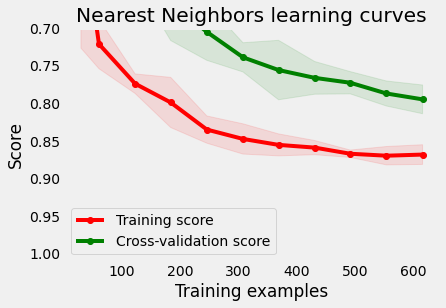

In [63]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Decision Tree

In [64]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 84.97 % 


f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


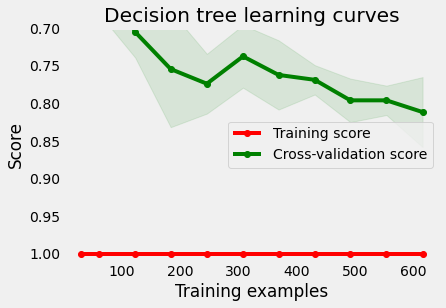

In [65]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Random forest

In [66]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Precision: 91.71 % 


In [67]:
rf.grid.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=40)

f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


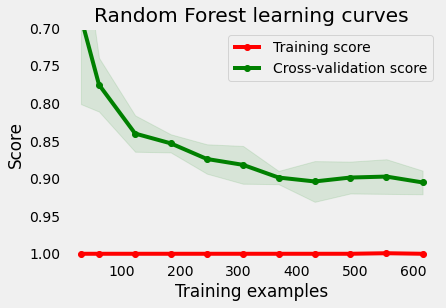

In [68]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Gradient Boosting

In [69]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Precision: 92.23 % 


f:\AnacondaPackage\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


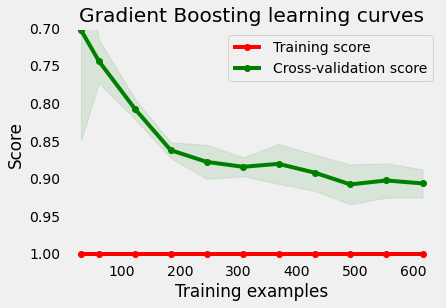

In [70]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [71]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [72]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')  

In [73]:
votingC = votingC.fit(X_train, Y_train)

In [74]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 92.23 % 


In [75]:
import pickle

In [76]:
def save_model(model_name,model):
    with open(f'../weight_model/{model_name}.pkl','wb') as f:
        pickle.dump(model,f)

In [77]:
save_model('votingC',votingC)

In [78]:
def save_csv(file_name,data):
    data.to_csv(f'../dataset/{file_name}.csv',index=False)

In [79]:
save_csv('X_train',X_train)
save_csv('Y_train',Y_train)
save_csv('X_test',X_test)
save_csv('Y_test',Y_test)